# **<font color="yellow"> Análise de Comentários do IMDB(pt)</font>**


O conjunto de dados IMDb é um dos benchmarks mais reconhecidos e amplamente utilizados no campo de modelos de classificação de textos. **O dataset é derivado do Internet Movie Database (IMDb)**, uma vasta base de dados online sobre filmes, programas de TV e celebridades.

O objetivo principal do uso do conjunto de dados IMDb em projetos de classificação de textos é **treinar modelos para discernir entre avaliações positivas e negativas de filmes com base nos comentários textuais**. Isso contribui para o avanço de técnicas de análise de sentimentos e compreensão de linguagem natural.

## **Dicionário de Dados**

| Chave      | Descrição                                                     |
|------------|---------------------------------------------------------------|
| ID         | Identificador único associado a cada entrada no conjunto de dados.|
| Review Text| O texto da crítica ou comentário do filme fornecido pelos usuários do IMDb.|
| Sentiment  | A classe ou rótulo atribuído à crítica, indicando se é positiva ou negativa. Pode ser binário (Positivo/Negativo) ou em formato de escala, dependendo da formulação do problema.|


## **Inciando a SparkSession e Importando os Dados**

In [1]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder\
      .master('local[*]')\
      .appName("analise_nlp")\
      .getOrCreate()

In [3]:
dados = spark.read.csv('/content/imdb-reviews-pt-br.csv',
                       escape = '\"',
                       header = True,
                       inferSchema = True)

## **Exploração dos Dados**

In [4]:
print(f' O número de linhas é: {dados.count()}\n', f'O número de colunas é: {len(dados.columns)}')

 O número de linhas é: 49459
 O número de colunas é: 4


In [5]:
dados.printSchema()

root
 |-- id: integer (nullable = true)
 |-- text_en: string (nullable = true)
 |-- text_pt: string (nullable = true)
 |-- sentiment: string (nullable = true)



In [6]:
dados.limit(10).show()

+---+--------------------+--------------------+---------+
| id|             text_en|             text_pt|sentiment|
+---+--------------------+--------------------+---------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|
|  2|This is an exampl...|Este é um exemplo...|      neg|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|
|  5|Brass pictures mo...|Filmes de fotos d...|      neg|
|  6|A funny thing hap...|Uma coisa engraça...|      neg|
|  7|This German horro...|Este filme de ter...|      neg|
|  8|Being a long-time...|Sendo um fã de lo...|      neg|
|  9|"Tokyo Eyes" tell...|"Tokyo Eyes" fala...|      neg|
| 10|Wealthy horse ran...|Fazendeiros ricos...|      neg|
+---+--------------------+--------------------+---------+



In [7]:
#Apresentando exemplos de comentário negativo e positivo

print("Comentário Negativo")
dados.filter(dados.id == 180).select("text_pt","sentiment").show(truncate = False)

print("Comentário Positivo")
dados.filter(dados.id == 12427).select("text_pt","sentiment").show(truncate = False)


Comentário Negativo
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------+
|text_pt                                                                                                                                                                                                                                                                                                                              |sentiment|
+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [8]:
#Contabilizando os tipos de comentários

dados.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



Com a contabilização dos dados, conseguimos enxergar que **os dados estão relativamente balanceados** - algo de importância na hora da aplicação de NLP

## **Limpeza dos Dados**

Vamos começar explorando a Nuvem de Palavras. **A abordagem inicial consiste em extrair as palavras-chave** e aplicar a função "collect()" em uma amostra, permitindo assim a **identificação das palavras mais frequentes no texto**. Essa análise nos proporcionará insights sobre a frequência das palavras no conjunto de dados.

In [9]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

In [10]:
seed = 123
np.random.seed(seed)

amostra = dados.select('text_pt').sample(fraction = 0.1, seed = seed)
tudo = [texto['text_pt'] for texto in amostra.collect()]

In [11]:
wordCloud = WordCloud(collocations = False, background_color = 'white',
                      prefer_horizontal = 1,
                      width = 800,
                      height = 600).generate(str(tudo))

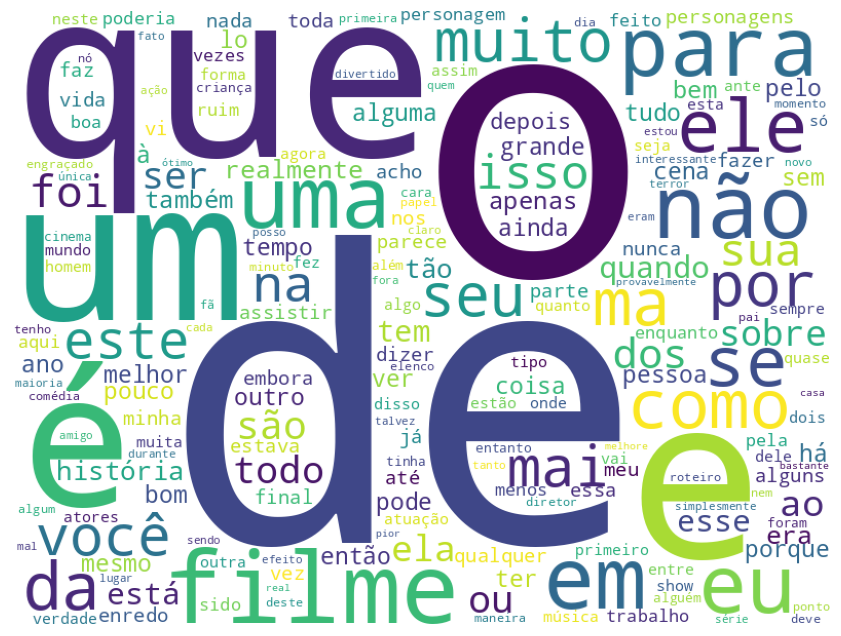

In [12]:
plt.figure(figsize = (12,8))
plt.imshow(wordCloud)
plt.axis('off')
plt.show()

Analisando a nuvem de palavras, o conjunto de textos apresenta diversos ruídos (caracteres especiais como "&", "!" , "/" ; e stop words como "de", "o", "e" , "que" , "para" , etc.), que são irrelevantes e prejudicam a identificação dos padrões. Por isso, vamos identificá-las e removê-las

## **Tokenização**

### Remoção dos caracteres especiais


In [28]:
import pyspark.sql.functions as f
from pyspark.ml.feature import Tokenizer
from pyspark.sql.types import IntegerType

dados = dados.withColumn('texto_regex',
                         f.regexp_replace('text_en', "[\$#,\"!%&'()*+-./;;<=>?@^_`´{|}~\\\\]", ""))

dados = dados.withColumn('texto_limpo', f.trim(dados.texto_regex))

dados.limit(2).show(truncate = False)


+---+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Tokenizer

In [30]:
tokenizer = Tokenizer(inputCol = 'texto_limpo', outputCol = 'tokens')
tokenizado = tokenizer.transform(dados)

In [31]:
tokenizado.select('texto_limpo','tokens').show()

+--------------------+--------------------+
|         texto_limpo|              tokens|
+--------------------+--------------------+
|Once again Mr Cos...|[once, again, mr,...|
|This is an exampl...|[this, is, an, ex...|
|First of all I ha...|[first, of, all, ...|
|Not even the Beat...|[not, even, the, ...|
|Brass pictures mo...|[brass, pictures,...|
|A funny thing hap...|[a, funny, thing,...|
|This German horro...|[this, german, ho...|
|Being a longtime ...|[being, a, longti...|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|
|Wealthy horse ran...|[wealthy, horse, ...|
|Cage plays a drun...|[cage, plays, a, ...|
|First of all I wo...|[first, of, all, ...|
|So tell me  what ...|[so, tell, me, , ...|
|A big disappointm...|[a, big, disappoi...|
|This film is abso...|[this, film, is, ...|
|Heres a decidedly...|[heres, a, decide...|
|At the bottom end...|[at, the, bottom,...|
|Earth has been de...|[earth, has, been...|
|Many people are s...|[many, people, ar...|
|New York family i...|[new, york

In [33]:
countTokens = f.udf(lambda tokens: len(tokens), IntegerType())

tokenizado.select("texto_limpo", "tokens")\
                 .withColumn("Freq_tokens", countTokens(f.col("tokens"))).show()

+--------------------+--------------------+-----------+
|         texto_limpo|              tokens|Freq_tokens|
+--------------------+--------------------+-----------+
|Once again Mr Cos...|[once, again, mr,...|        168|
|This is an exampl...|[this, is, an, ex...|        232|
|First of all I ha...|[first, of, all, ...|        215|
|Not even the Beat...|[not, even, the, ...|        308|
|Brass pictures mo...|[brass, pictures,...|        238|
|A funny thing hap...|[a, funny, thing,...|        115|
|This German horro...|[this, german, ho...|        156|
|Being a longtime ...|[being, a, longti...|        136|
|Tokyo Eyes tells ...|[tokyo, eyes, tel...|        129|
|Wealthy horse ran...|[wealthy, horse, ...|        160|
|Cage plays a drun...|[cage, plays, a, ...|        109|
|First of all I wo...|[first, of, all, ...|        333|
|So tell me  what ...|[so, tell, me, , ...|        243|
|A big disappointm...|[a, big, disappoi...|        110|
|This film is abso...|[this, film, is, ...|     

### StopWords

In [35]:
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from pyspark.ml.feature import StopWordsRemover


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [36]:
dicio = stopwords.words("english")
remover = StopWordsRemover(inputCol = 'tokens', outputCol = 'texto_final', stopWords = dicio)
feature_data = remover.transform(tokenizado)

In [37]:
feature_data.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|              tokens|         texto_final|
+---+--------------------+--------------------+---------+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|[once, again, mr,...|[mr, costner, dra...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|[this, is, an, ex...|[example, majorit...|
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|[first, of, all, ...|[first, hate, mor...|
|  4|Not even the Beat...|Nem mesmo os Beat...|      neg|Not even the Beat...|Not even the Beat...|[not, even, the, ...|[even, beatles, c...|
|  5|B

In [38]:
feature_data.select("tokens", "texto_final")\
                    .withColumn("Freq_tokens", countTokens(f.col("tokens")))\
                    .withColumn("Fre_tokens_limpos", countTokens(f.col("texto_final"))).show()

+--------------------+--------------------+-----------+-----------------+
|              tokens|         texto_final|Freq_tokens|Fre_tokens_limpos|
+--------------------+--------------------+-----------+-----------------+
|[once, again, mr,...|[mr, costner, dra...|        168|               74|
|[this, is, an, ex...|[example, majorit...|        232|              131|
|[first, of, all, ...|[first, hate, mor...|        215|              111|
|[not, even, the, ...|[even, beatles, c...|        308|              170|
|[brass, pictures,...|[brass, pictures,...|        238|              140|
|[a, funny, thing,...|[funny, thing, ha...|        115|               53|
|[this, german, ho...|[german, horror, ...|        156|               75|
|[being, a, longti...|[longtime, fan, j...|        136|               74|
|[tokyo, eyes, tel...|[tokyo, eyes, tel...|        129|               75|
|[wealthy, horse, ...|[wealthy, horse, ...|        160|               99|
|[cage, plays, a, ...|[cage, plays, dr

## **Vetorização das palavras**

Iremos fazer nessa parte o processo de Bag of Words, que contabiliza a quantidade de palavras do nosso vocabulário e limita a quantidade de palavras deste.

In [41]:
from pyspark.ml.feature import CountVectorizer
from pyspark.ml.feature import HashingTF

In [40]:
cv = CountVectorizer(inputCol = 'texto_final', outputCol = 'CountVec')
model = cv.fit(feature_data)
countVectorizer_features = model.transform(feature_data)

countVectorizer_features.select('texto_final','CountVec').limit(5).show()

+--------------------+--------------------+
|         texto_final|            CountVec|
+--------------------+--------------------+
|[mr, costner, dra...|(221176,[0,8,9,12...|
|[example, majorit...|(221176,[1,2,3,9,...|
|[first, hate, mor...|(221176,[0,2,4,12...|
|[even, beatles, c...|(221176,[0,1,2,4,...|
|[brass, pictures,...|(221176,[1,3,5,9,...|
+--------------------+--------------------+



In [43]:
hashingTF = HashingTF(inputCol = 'texto_final', outputCol = 'hashingTF')
hashingTF.setNumFeatures(100)

htfFeaturizedData = hashingTF.transform(countVectorizer_features)


In [44]:
htfFeaturizedData.select('texto_final','hashingTF').limit(5).show()

+--------------------+--------------------+
|         texto_final|           hashingTF|
+--------------------+--------------------+
|[mr, costner, dra...|(100,[5,10,11,12,...|
|[example, majorit...|(100,[0,2,3,5,6,7...|
|[first, hate, mor...|(100,[0,1,2,3,5,6...|
|[even, beatles, c...|(100,[0,3,5,6,7,8...|
|[brass, pictures,...|(100,[0,2,3,5,6,7...|
+--------------------+--------------------+



## **Estabelecendo o peso das palavras**

O TF-IDF, uma métrica estatística, destaca a importância de uma palavra no conjunto de dados, levando em conta sua frequência não apenas na linha específica, mas em todo o corpus textual. Essa medida é amplamente empregada em recuperação de informações e mineração de dados.

In [46]:
from pyspark.ml.feature import IDF

In [47]:
idf = IDF(inputCol = 'hashingTF', outputCol = 'features')
idfModel = idf.fit(htfFeaturizedData)
tfIDFFeaturizedData = idfModel.transform(htfFeaturizedData)

In [49]:
tfIDFFeaturizedData.select('texto_final','features').limit(5).show(truncate = False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## **Codificação da Variável Resposta**

Agora, ensinaremos para a máquina que todas essas palavras estarão associadas ao sentimento do comentário, **codificando então neg e pos para 0 e 1**. Depois, otimizaremos as etapas anteriores para criar nossa base de dados para a aplicação do processo de classificação

In [50]:
tfIDFFeaturizedData.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|      pos|24694|
|      neg|24765|
+---------+-----+



In [51]:
from pyspark.ml.feature import StringIndexer

stringIndexer = StringIndexer(inputCol = 'sentiment', outputCol = 'label')
dados = stringIndexer.fit(dados).transform(dados)

In [54]:
dados.groupBy('sentiment','label').count().show()

+---------+-----+-----+
|sentiment|label|count|
+---------+-----+-----+
|      pos|  1.0|24694|
|      neg|  0.0|24765|
+---------+-----+-----+



In [57]:
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol = 'texto_limpo', outputCol = 'tokens')
stopwords = StopWordsRemover(inputCol = 'tokens', outputCol = 'texto_final', stopWords = dicio)
hashingTF = HashingTF(inputCol = 'texto_final', outputCol = 'HTF', numFeatures= 1000)
tfIDF = IDF(inputCol= 'HTF' , outputCol = 'features' )

pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfIDF])

In [58]:
dados_transformados = pipeline.fit(dados).transform(dados)

In [59]:
dados_transformados.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+
|  1|Once again Mr. Co...|Mais uma vez, o S...|      neg|Once again Mr Cos...|Once again Mr Cos...|  0.0|[once, again, mr,...|[mr, costner, dra...|(1000,[10,21,34,4...|(1000,[10,21,34,4...|
|  2|This is an exampl...|Este é um exemplo...|      neg|This is an exampl...|This is an exampl...|  0.0|[this, is, an, ex...|[example, majorit...|(1000,[0,3,11,12,...|(1000,[0,3,11,12,...|
|  3|First of all I ha...|Primeiro de tudo ...|   

## **Árvore de Decisão**

In [60]:
featureDF = dados_transformados.select('features','label')

In [61]:
featureDF.limit(5).show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|(1000,[10,21,34,4...|  0.0|
|(1000,[0,3,11,12,...|  0.0|
|(1000,[1,7,33,38,...|  0.0|
|(1000,[0,3,10,12,...|  0.0|
|(1000,[3,6,7,11,3...|  0.0|
+--------------------+-----+



In [64]:
#pipeline de transformação e ajuste

from pyspark.ml.classification import DecisionTreeClassifier

tokenizer = Tokenizer(inputCol = 'texto_limpo', outputCol = 'tokens')
stopwords = StopWordsRemover(inputCol = 'tokens', outputCol = 'texto_final', stopWords = dicio)
hashingTF = HashingTF(inputCol = 'texto_final', outputCol = 'HTF', numFeatures= 1000)
tfIDF = IDF(inputCol= 'HTF' , outputCol = 'features' )
dtc = DecisionTreeClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 10, seed = seed)


pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfIDF, dtc])

In [65]:
train, test = dados.randomSplit([0.7,0.3], seed = seed)
dtc_model = pipeline.fit(train)

Exception ignored in: <function JavaWrapper.__del__ at 0x7fadb47931c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'DecisionTreeClassifier' object has no attribute '_java_obj'


In [66]:
predictions = dtc_model.transform(test)

In [67]:
predictions.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|  0.0|[first, of, all, ...|[first, hate, mor...|(1000,[1,7,33,38,...|(1000,[1,7,33,38,...|  [712.0,385.0]|[0.64904284412032...|       0.0|
|  7|This German horro...|Este filme de ter...| 

### Métricas

In [68]:
predictions.select(['label','prediction']).show()

+-----+----------+
|label|prediction|
+-----+----------+
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
|  0.0|       1.0|
|  0.0|       0.0|
+-----+----------+
only showing top 20 rows



In [69]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator()

In [70]:
print("Acurácia: %f" % evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
print("Precisão: %f" % evaluator.evaluate(predictions, {evaluator.metricName: "precisionByLabel", evaluator.metricLabel: 1}))
print("Recall: %f" % evaluator.evaluate(predictions, {evaluator.metricName: "recallByLabel", evaluator.metricLabel: 1}))
print("F1: %f" % evaluator.evaluate(predictions, {evaluator.metricName: "fMeasureByLabel", evaluator.metricLabel: 1}))

Acurácia: 0.673717
Precisão: 0.654775
Recall: 0.719869
F1: 0.685781


#### Matriz de Confusão

In [107]:
tp = predictions.select('label','prediction').where((f.col('label') == 1) & (f.col('prediction') == 1)).count()
tn = predictions.select('label','prediction').where((f.col('label') == 0) & (f.col('prediction') == 0)).count()
fp = predictions.select('label','prediction').where((f.col('label') == 0) & (f.col('prediction') == 1)).count()
fn = predictions.select('label','prediction').where((f.col('label') == 1) & (f.col('prediction') == 0)).count()



print(' '*20, 'Previsto')
print(' '*4,'-'*3)
print(' '*4,'|',' '*9, 'Churn', ' '*5 ,'Não-Churn')
print(' '*4,'|','Churn', ' '*6, int(tp), ' '*7, int(fn))
print('Real','|')
print(' '*4,'|', 'Não-Churn', ' '*2, int(fp), ' '*7, int(tn))

                     Previsto
     ---
     |           Churn       Não-Churn
     | Churn        5286         2057
Real |
     | Não-Churn    2787         4716


In [108]:
predictions.count()

14846

### Cross Validation

In [136]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

tokenizer = Tokenizer(inputCol='texto_limpo', outputCol='tokens')
stopwords = StopWordsRemover(inputCol='tokens', outputCol='texto_final', stopWords=dicio)
hashingTF = HashingTF(inputCol='texto_final', outputCol='HTF', numFeatures=1000)
tfIDF = IDF(inputCol='HTF', outputCol='features')
dtc = DecisionTreeClassifier(featuresCol='features', labelCol='label', maxDepth=10, seed=seed)


pipeline = Pipeline(stages=[tokenizer, stopwords, hashingTF, tfIDF, dtc])

grid = ParamGridBuilder() \
    .addGrid(dtc.maxDepth, [2, 5, 10]) \
    .addGrid(dtc.maxBins, [10, 32, 45]) \
    .build()

evaluator = MulticlassClassificationEvaluator()


dtc_cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3,
    seed=seed
)


train, test = dados.randomSplit([0.7, 0.3], seed=seed)


modelo_dtc_cv = dtc_cv.fit(train)

previsoes_dtc_cv_teste = modelo_dtc_cv.transform(test)


In [131]:
previsoes_dtc_cv_teste.limit(5).show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|  rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+---------------+--------------------+----------+
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|  0.0|[first, of, all, ...|[first, hate, mor...|(1000,[1,7,33,38,...|(1000,[1,7,33,38,...|  [712.0,385.0]|[0.64904284412032...|       0.0|
|  7|This German horro...|Este filme de ter...| 

#### Métricas

In [130]:
print("Acurácia: %f" % evaluator.evaluate(previsoes_dtc_cv_teste, {evaluator.metricName: "accuracy"}))
print("Precisão: %f" % evaluator.evaluate(previsoes_dtc_cv_teste, {evaluator.metricName: "precisionByLabel", evaluator.metricLabel: 1}))
print("Recall: %f" % evaluator.evaluate(previsoes_dtc_cv_teste, {evaluator.metricName: "recallByLabel", evaluator.metricLabel: 1}))
print("F1: %f" % evaluator.evaluate(previsoes_dtc_cv_teste, {evaluator.metricName: "fMeasureByLabel", evaluator.metricLabel: 1}))

Acurácia: 0.674256
Precisão: 0.655117
Recall: 0.720959
F1: 0.686463


#### Matriz de Confusão

In [132]:
tp = previsoes_dtc_cv_teste.select('label','prediction').where((f.col('label') == 1) & (f.col('prediction') == 1)).count()
tn = previsoes_dtc_cv_teste.select('label','prediction').where((f.col('label') == 0) & (f.col('prediction') == 0)).count()
fp = previsoes_dtc_cv_teste.select('label','prediction').where((f.col('label') == 0) & (f.col('prediction') == 1)).count()
fn = previsoes_dtc_cv_teste.select('label','prediction').where((f.col('label') == 1) & (f.col('prediction') == 0)).count()



print(' '*20, 'Previsto')
print(' '*4,'-'*3)
print(' '*4,'|',' '*9, 'Churn', ' '*5 ,'Não-Churn')
print(' '*4,'|','Churn', ' '*6, int(tp), ' '*7, int(fn))
print('Real','|')
print(' '*4,'|', 'Não-Churn', ' '*2, int(fp), ' '*7, int(tn))

                     Previsto
     ---
     |           Churn       Não-Churn
     | Churn        5294         2049
Real |
     | Não-Churn    2787         4716


## **Random Forest Classifier**

In [115]:
featureDF = dados_transformados.select('features','label')

In [118]:
from pyspark.ml.classification import RandomForestClassifier

tokenizer = Tokenizer(inputCol = 'texto_limpo', outputCol = 'tokens')
stopwords = StopWordsRemover(inputCol = 'tokens', outputCol = 'texto_final', stopWords = dicio)
hashingTF = HashingTF(inputCol = 'texto_final', outputCol = 'HTF', numFeatures= 1000)
tfIDF = IDF(inputCol= 'HTF' , outputCol = 'features' )
rfd = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 10, numTrees= 10, seed = seed)


pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfIDF, rfd])

In [120]:
train, test = dados.randomSplit([0.7,0.3], seed = seed)
rdf_model = pipeline.fit(train)

In [121]:
predictions_rdf = rdf_model.transform(test)

In [122]:
predictions_rdf.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|       rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|  0.0|[first, of, all, ...|[first, hate, mor...|(1000,[1,7,33,38,...|(1000,[1,7,33,38,...|[5.78700165122097...|[0.57870016512209...|       0.0|
|  7|This German horro...|Es

### Métricas

In [124]:
print("Acurácia: %f" % evaluator.evaluate(predictions_rdf, {evaluator.metricName: "accuracy"}))
print("Precisão: %f" % evaluator.evaluate(predictions_rdf, {evaluator.metricName: "precisionByLabel", evaluator.metricLabel: 1}))
print("Recall: %f" % evaluator.evaluate(predictions_rdf, {evaluator.metricName: "recallByLabel", evaluator.metricLabel: 1}))
print("F1: %f" % evaluator.evaluate(predictions_rdf, {evaluator.metricName: "fMeasureByLabel", evaluator.metricLabel: 1}))

Acurácia: 0.715344
Precisão: 0.695915
Recall: 0.753915
F1: 0.723755


In [125]:
tp = predictions_rdf.select('label','prediction').where((f.col('label') == 1) & (f.col('prediction') == 1)).count()
tn = predictions_rdf.select('label','prediction').where((f.col('label') == 0) & (f.col('prediction') == 0)).count()
fp = predictions_rdf.select('label','prediction').where((f.col('label') == 0) & (f.col('prediction') == 1)).count()
fn = predictions_rdf.select('label','prediction').where((f.col('label') == 1) & (f.col('prediction') == 0)).count()



print(' '*20, 'Previsto')
print(' '*4,'-'*3)
print(' '*4,'|',' '*9, 'Churn', ' '*5 ,'Não-Churn')
print(' '*4,'|','Churn', ' '*6, int(tp), ' '*7, int(fn))
print('Real','|')
print(' '*4,'|', 'Não-Churn', ' '*2, int(fp), ' '*7, int(tn))

                     Previsto
     ---
     |           Churn       Não-Churn
     | Churn        5536         1807
Real |
     | Não-Churn    2419         5084


### Cross Validation

In [139]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline

tokenizer = Tokenizer(inputCol='texto_limpo', outputCol='tokens')
stopwords = StopWordsRemover(inputCol='tokens', outputCol='texto_final', stopWords=dicio)
hashingTF = HashingTF(inputCol='texto_final', outputCol='HTF', numFeatures=1000)
tfIDF = IDF(inputCol='HTF', outputCol='features')
rfc = RandomForestClassifier(featuresCol='features', labelCol='label', maxDepth=10, numTrees=10, seed=seed)

pipeline = Pipeline(stages=[tokenizer, stopwords, hashingTF, tfIDF, rfc])

grid = ParamGridBuilder() \
    .addGrid(rfc.maxDepth, [2, 5, 10]) \
    .addGrid(rfc.maxBins, [10, 32, 45]) \
    .addGrid(rfc.numTrees, [10, 20, 50]) \
    .build()

evaluator = MulticlassClassificationEvaluator()

rfc_cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3,
    seed=seed
)

train, test = dados.randomSplit([0.7, 0.3], seed=seed)

modelo_rfc_cv = rfc_cv.fit(train)

previsoes_rfc_cv_teste = modelo_rfc_cv.transform(test)


In [140]:
previsoes_rfc_cv_teste.show()

+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| id|             text_en|             text_pt|sentiment|         texto_regex|         texto_limpo|label|              tokens|         texto_final|                 HTF|            features|       rawPrediction|         probability|prediction|
+---+--------------------+--------------------+---------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  3|First of all I ha...|Primeiro de tudo ...|      neg|First of all I ha...|First of all I ha...|  0.0|[first, of, all, ...|[first, hate, mor...|(1000,[1,7,33,38,...|(1000,[1,7,33,38,...|[28.5643047217444...|[0.57128609443488...|       0.0|
|  7|This German horro...|Es

#### Métricas

In [142]:
print("Acurácia: %f" % evaluator.evaluate(previsoes_rfc_cv_teste, {evaluator.metricName: "accuracy"}))
print("Precisão: %f" % evaluator.evaluate(previsoes_rfc_cv_teste, {evaluator.metricName: "precisionByLabel", evaluator.metricLabel: 1}))
print("Recall: %f" % evaluator.evaluate(previsoes_rfc_cv_teste, {evaluator.metricName: "recallByLabel", evaluator.metricLabel: 1}))
print("F1: %f" % evaluator.evaluate(previsoes_rfc_cv_teste, {evaluator.metricName: "fMeasureByLabel", evaluator.metricLabel: 1}))

Acurácia: 0.745453
Precisão: 0.724716
Recall: 0.782650
F1: 0.752570


#### Matriz de Confusão

In [143]:
tp = previsoes_rfc_cv_teste.select('label','prediction').where((f.col('label') == 1) & (f.col('prediction') == 1)).count()
tn = previsoes_rfc_cv_teste.select('label','prediction').where((f.col('label') == 0) & (f.col('prediction') == 0)).count()
fp = previsoes_rfc_cv_teste.select('label','prediction').where((f.col('label') == 0) & (f.col('prediction') == 1)).count()
fn = previsoes_rfc_cv_teste.select('label','prediction').where((f.col('label') == 1) & (f.col('prediction') == 0)).count()



print(' '*20, 'Previsto')
print(' '*4,'-'*3)
print(' '*4,'|',' '*9, 'Churn', ' '*5 ,'Não-Churn')
print(' '*4,'|','Churn', ' '*6, int(tp), ' '*7, int(fn))
print('Real','|')
print(' '*4,'|', 'Não-Churn', ' '*2, int(fp), ' '*7, int(tn))

                     Previsto
     ---
     |           Churn       Não-Churn
     | Churn        5747         1596
Real |
     | Não-Churn    2183         5320


## **Nova Frase p/ Teste**

### **<font color="yellow">Melhor Modelo</font>**

In [145]:
melhor_modelo_rfc_cv = modelo_rfc_cv.bestModel


In [149]:
melhor_modelo_rfc_cv = modelo_rfc_cv.bestModel
melhor_rfc_modelo = melhor_modelo_rfc_cv.stages[-1]

print("Max Depth:", melhor_rfc_modelo.getMaxDepth())
print("Max Bins:", melhor_rfc_modelo.getMaxBins())
print("Num Trees:", melhor_rfc_modelo.getNumTrees)

Max Depth: 10
Max Bins: 10
Num Trees: 50


In [151]:
tokenizer = Tokenizer(inputCol = 'texto_limpo', outputCol = 'tokens')
stopwords = StopWordsRemover(inputCol = 'tokens', outputCol = 'texto_final', stopWords = dicio)
hashingTF = HashingTF(inputCol = 'texto_final', outputCol = 'HTF', numFeatures= 1000)
tfIDF = IDF(inputCol= 'HTF' , outputCol = 'features' )
rfd = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', maxDepth = 10, numTrees= 50, maxBins = 10, seed = seed)


pipeline = Pipeline(stages = [tokenizer, stopwords, hashingTF, tfIDF, rfd])

train, test = dados.randomSplit([0.7,0.3], seed = seed)
rdf_model_tunned = pipeline.fit(train)

# **<font color="yellow">Nova Frase</font>**

In [152]:
nova_base = spark.createDataFrame([
        (1, "This is without doubt the worst movie i have ever seen, I hated the acting of the actor."),
        (0, "I loved the movie, excellent acting!"),
    ], ["id", "texto_limpo"])

In [153]:
nova_classe = rdf_model_tunned.transform(nova_base)

In [154]:
nova_classe.show()

+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
| id|         texto_limpo|              tokens|         texto_final|                 HTF|            features|       rawPrediction|         probability|prediction|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|  1|This is without d...|[this, is, withou...|[without, doubt, ...|(1000,[35,43,269,...|(1000,[35,43,269,...|[25.4913080982498...|[0.50982616196499...|       0.0|
|  0|I loved the movie...|[i, loved, the, m...|[loved, movie,, e...|(1000,[185,543,73...|(1000,[185,543,73...|[19.3275680015213...|[0.38655136003042...|       1.0|
+---+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+----------+



As classificações foram feitas corretamente. Mostrando que **o modelo está funcionando.**